In [5]:
import matplotlib
%matplotlib inline
%config InLineBackend.figure_format='svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [6]:
from tqdm import tqdm_notebook
import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl
#from helper_code import *
import pandas as pd

In [7]:
dataset=pd.read_csv('dataset.csv')
dataset

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


In [8]:
dataset.columns

Index(['Text', 'language'], dtype='object')

## Data Exploration and Visualization

In [9]:
len(dataset)

22000

In [10]:
languages=set(dataset['language'])
languages

{'Arabic',
 'Chinese',
 'Dutch',
 'English',
 'Estonian',
 'French',
 'Hindi',
 'Indonesian',
 'Japanese',
 'Korean',
 'Latin',
 'Persian',
 'Portugese',
 'Pushto',
 'Romanian',
 'Russian',
 'Spanish',
 'Swedish',
 'Tamil',
 'Thai',
 'Turkish',
 'Urdu'}

In [11]:
language_list=list(languages)
language_list

['English',
 'Thai',
 'Pushto',
 'Romanian',
 'Spanish',
 'Swedish',
 'Dutch',
 'French',
 'Latin',
 'Korean',
 'Turkish',
 'Arabic',
 'Estonian',
 'Urdu',
 'Japanese',
 'Portugese',
 'Tamil',
 'Hindi',
 'Indonesian',
 'Chinese',
 'Persian',
 'Russian']

In [12]:
raw_data={}
for i in range(len(dataset)):
    raw_data.setdefault(dataset['language'][i], [])
    raw_data[dataset['language'][i]].append(dataset['Text'][i])

In [13]:
raw_data['English']

['in  johnson was awarded an american institute of architects gold medal in  he became the first recipient of the pritzker architecture prize the most prestigious international architectural award',
 'bussy-saint-georges has built its identity on a green model environment with parks and gardens they represent  hectares of integrated green spaces  kilometres  miles of soft connecting links  squares and parks in the city centre  pools and more than  trees today',
 'minnesotas state parks are spread across the state in such a way that there is a state park within  miles  km of every minnesotan the most recent park created is lake vermilion state park created in  currently the parks range in size from franz jevne state park with  acres  ha to saint croix state park with  acres  ha two parks include resources listed as national natural landmarks big bog state recreation area and itasca state park and six parks encompass national historic landmarks charles a lindbergh fort snelling mille lac

In [14]:
def stats(data):
    count=0
    for language,sentences in data.items():
        #join method joins the values in sentences seperated by the preceeding mentioned ' '.
        #split() method splits the string into list of words. Seperator para by default is ' '.
        word_list=' '.join(str(sentences)).split()
        num_sentences=len(sentences)
        num_words=len(word_list)
        num_unique_words=len(set(word_list))
        sample_extract=' '.join(str(sentences[0]).split()[0:7])
        count+=1
        print("Language : ",language)
        print("Number of sentences : ",num_sentences)
        print("Number of words : ",num_words)
        print("Number of unique words : ",num_unique_words)
        print("Sample extract : ",sample_extract)
        print("-----------------------------------------------------------------------------")
    print("Number of languages = ",count)

In [15]:
stats(raw_data)

Language :  Estonian
Number of sentences :  1000
Number of words :  268430
Number of unique words :  151
Sample extract :  klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi
-----------------------------------------------------------------------------
Language :  Swedish
Number of sentences :  1000
Number of words :  268903
Number of unique words :  174
Sample extract :  sebes joseph pereira thomas på eng the
-----------------------------------------------------------------------------
Language :  Thai
Number of sentences :  1000
Number of words :  346577
Number of unique words :  407
Sample extract :  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เริ่มตั้งแต่ถนนสนามไชยถึงแม่น้ำเจ้าพระยาที่ถนนตก กรุงเทพมหานคร
-----------------------------------------------------------------------------
Language :  Tamil
Number of sentences :  1000
Number of words :  315683
Number of unique words :  251
Sample extract :  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திரிகை-விசாகப்பட்டின ஆசிர

In [16]:
def zipf_graph(data):
    languages=list(data.keys())
    words_dict=dict()
    for language in languages:
        words_dict[language]=pd.DataFrame()
        words=[]
        for sentence in data[language]:
            words.extend(str(sentence).split())
        words_dict[language]['word']=words
    plt.figure(figsize=(25,25))
    for language in languages:
        freqs=words_dict[language]['word'].value_counts().values
        ranks=range(1,len(freqs)+1)
        plt.plot(freqs,ranks, label=language)
        
    plt.ylabel('Frequency')
    plt.xlabel('Rank')
    plt.xscale('log')
    plt.yscale('log')
    
    plt.title('Zipf\'s Law')
    plt.legend()

C:\Users\Ishan SS\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Ishan SS\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


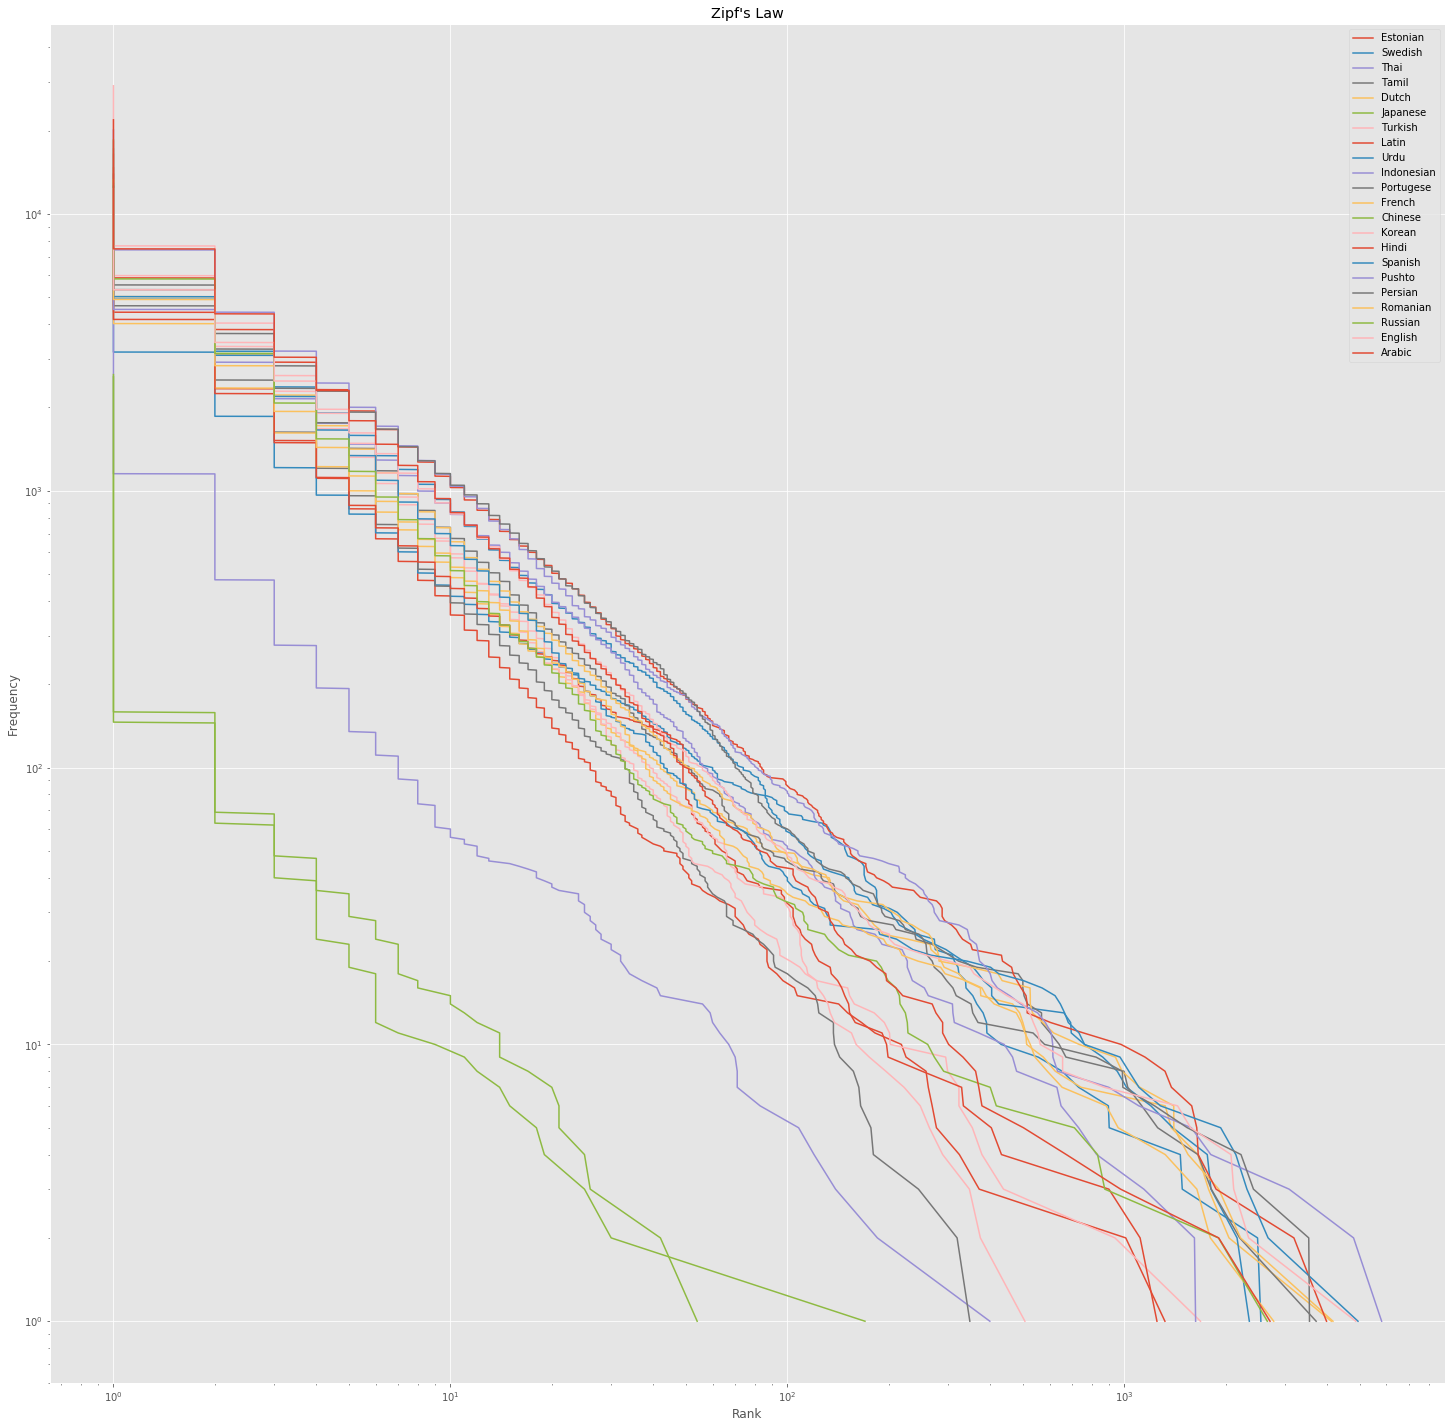

In [17]:
zipf_graph(raw_data)

## Data Preprocessing

In [18]:
str.translate?

In [19]:
def preprocess(text):
    prepro_text=str(text).lower().replace('-',' ')
    translation_table=str.maketrans('\n',' ',string.punctuation+string.digits)
    prepro_text=prepro_text.translate(translation_table)
    return prepro_text

In [20]:
prepro_data={k : [preprocess(sentences) for sentences in v] for k,v in raw_data.items()}

In [21]:
stats(prepro_data)

Language :  Estonian
Number of sentences :  1000
Number of words :  267301
Number of unique words :  144
Sample extract :  klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi
-----------------------------------------------------------------------------
Language :  Swedish
Number of sentences :  1000
Number of words :  268269
Number of unique words :  169
Sample extract :  sebes joseph pereira thomas på eng the
-----------------------------------------------------------------------------
Language :  Thai
Number of sentences :  1000
Number of words :  345664
Number of unique words :  401
Sample extract :  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เริ่มตั้งแต่ถนนสนามไชยถึงแม่น้ำเจ้าพระยาที่ถนนตก กรุงเทพมหานคร
-----------------------------------------------------------------------------
Language :  Tamil
Number of sentences :  1000
Number of words :  315141
Number of unique words :  241
Sample extract :  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திரிகை விசாகப்பட்டின ஆசிர

In [22]:
import random 
res = random.sample(range(1, 1001),1000)
res

[439,
 424,
 744,
 510,
 977,
 527,
 237,
 686,
 869,
 721,
 845,
 412,
 550,
 332,
 173,
 679,
 895,
 858,
 353,
 585,
 36,
 3,
 341,
 84,
 160,
 622,
 383,
 776,
 415,
 462,
 768,
 199,
 381,
 119,
 191,
 940,
 391,
 590,
 559,
 325,
 313,
 998,
 695,
 681,
 395,
 911,
 772,
 745,
 773,
 694,
 647,
 837,
 483,
 994,
 189,
 835,
 178,
 403,
 25,
 481,
 796,
 511,
 264,
 675,
 478,
 157,
 958,
 95,
 882,
 771,
 77,
 746,
 208,
 821,
 880,
 220,
 518,
 271,
 435,
 200,
 426,
 134,
 810,
 221,
 970,
 900,
 509,
 616,
 655,
 595,
 743,
 568,
 153,
 690,
 427,
 232,
 493,
 433,
 800,
 986,
 670,
 797,
 348,
 802,
 628,
 749,
 828,
 668,
 902,
 360,
 506,
 288,
 685,
 263,
 437,
 967,
 382,
 365,
 832,
 593,
 425,
 730,
 16,
 297,
 406,
 901,
 80,
 609,
 64,
 159,
 908,
 676,
 129,
 485,
 335,
 245,
 753,
 87,
 461,
 212,
 844,
 857,
 822,
 599,
 781,
 356,
 726,
 752,
 466,
 964,
 885,
 905,
 233,
 809,
 33,
 472,
 269,
 188,
 85,
 50,
 53,
 307,
 946,
 441,
 272,
 89,
 430,
 177,
 848,
 5

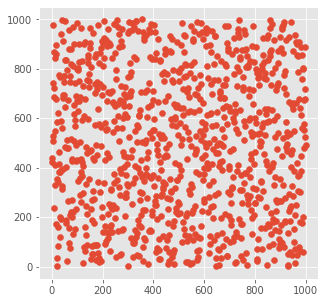

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(range(1,1001),res)

In [24]:
percent=0.7
size=1000

In [25]:
X_train,Y_train,X_test,Y_test=[],[],[],[]
sentence_count=int(percent*size)
for k,v in prepro_data.items():
    count=1
    for sentence in v:
        if count<=sentence_count:
            X_train.append(sentence)
            Y_train.append(k)
        else:
            X_test.append(sentence)
            Y_test.append(k)
        count+=1

In [26]:
X_train

['klement gottwaldi surnukeha palsameeriti ning paigutati mausoleumi surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemärke  aastal viidi ta surnukeha mausoleumist ära ja kremeeriti zlíni linn kandis aastatel – nime gottwaldov ukrainas harkivi oblastis kandis zmiivi linn aastatel – nime gotvald',
 'dorota rabczewska artistinimega doda sündinud  veebruaril  on kuulus poola rokk  ja poplaulja ta on kõige rohkem auhindu võitnud laulja poolas doda on tuntuks laulnud sellised hitid nagu szansa katharsis ja nie daj się',
 'merilai a maria kristiina lotman toim  methis studia humaniora estonica  poeetika erinumber tartu tartu ülikooli kirjastus',
 'teda on süüdistatud holokausti eitamises    aastal väitis ta new york posti arvamusloos et   juuti ei olnud võimalik tappa treblinka gaasikambis diiselmootori heitgaasidega ta väitis ka et treblinka ei olnud surmalaager vaid transiitlaager',
 'neile on omistatud vana kreeka laadide nimetused joonia door

In [27]:
len(X_train),len(X_test)

(15400, 6600)

In [28]:
vectorizer=CountVectorizer()
X_train=vectorizer.fit_transform(X_train)
X_train

<15400x216903 sparse matrix of type '<class 'numpy.int64'>'
	with 640517 stored elements in Compressed Sparse Row format>

In [29]:
print(X_train[2])

  (0, 54922)	1
  (0, 53009)	1
  (0, 46987)	1
  (0, 51085)	1
  (0, 87345)	1
  (0, 55140)	1
  (0, 82418)	1
  (0, 38246)	1
  (0, 27846)	1
  (0, 67262)	1
  (0, 27220)	1
  (0, 85078)	2
  (0, 98679)	1
  (0, 45582)	1


In [30]:
naive_clf=MultinomialNB()
naive_clf.fit(X_train,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
X_test=vectorizer.transform(X_test)
test_pred=naive_clf.predict(X_test)

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_pred, Y_test)

array([[299,  97,   0,   0,   0,   0,   0,   0,  73,   4,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 149,   0,   0,   0,   0,   0,   0,   4,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1, 294,   1,   0,   0,   0,   0,   1,   0,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  38,   1, 299,   5,   2,   7,   5,  11,   3,  16,   0,  14,
         11,   3,   1,   4,   0,   1,   5,   2,   3],
       [  0,   1,   0,   0, 292,   0,   0,   0,   1,   0,   1,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   3,   4,   0,   1, 297,   0,   0,   6,   0,   5,   0,   0,
          0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 293,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0,   0,   1,   0,   0, 294,   1,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   0, 

In [33]:
def plot_confusion_matrix(y_true,y_pred,classes,normalize=False,title=None,cmap=plt.cm.Blues):
    title='Confusion Matrix'
    cm=confusion_matrix(y_true,y_pred,labels=classes)
    fig,ax=plt.subplots(figsize=(20,20))
    im=ax.imshow(cm,interpolation='nearest',cmap=cmap)
    ax.figure.colorbar(im,ax=ax,fraction=0.046,pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
            yticks=np.arange(cm.shape[0]),
              xticklabels=classes,yticklabels=classes,
              title=title,
              ylabel='True Label',
              xlabel='Predicted Label')
    plt.setp(ax.get_xticklabels(),rotation=0)
    fmt='.2f' if normalize else 'd'
    thresh=cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,format(cm[i,j],fmt),ha="center",va="center",color="white" if cm[i,j]>thresh else "black")
    
    fig.tight_layout()
    
    plt.grid(b=None)

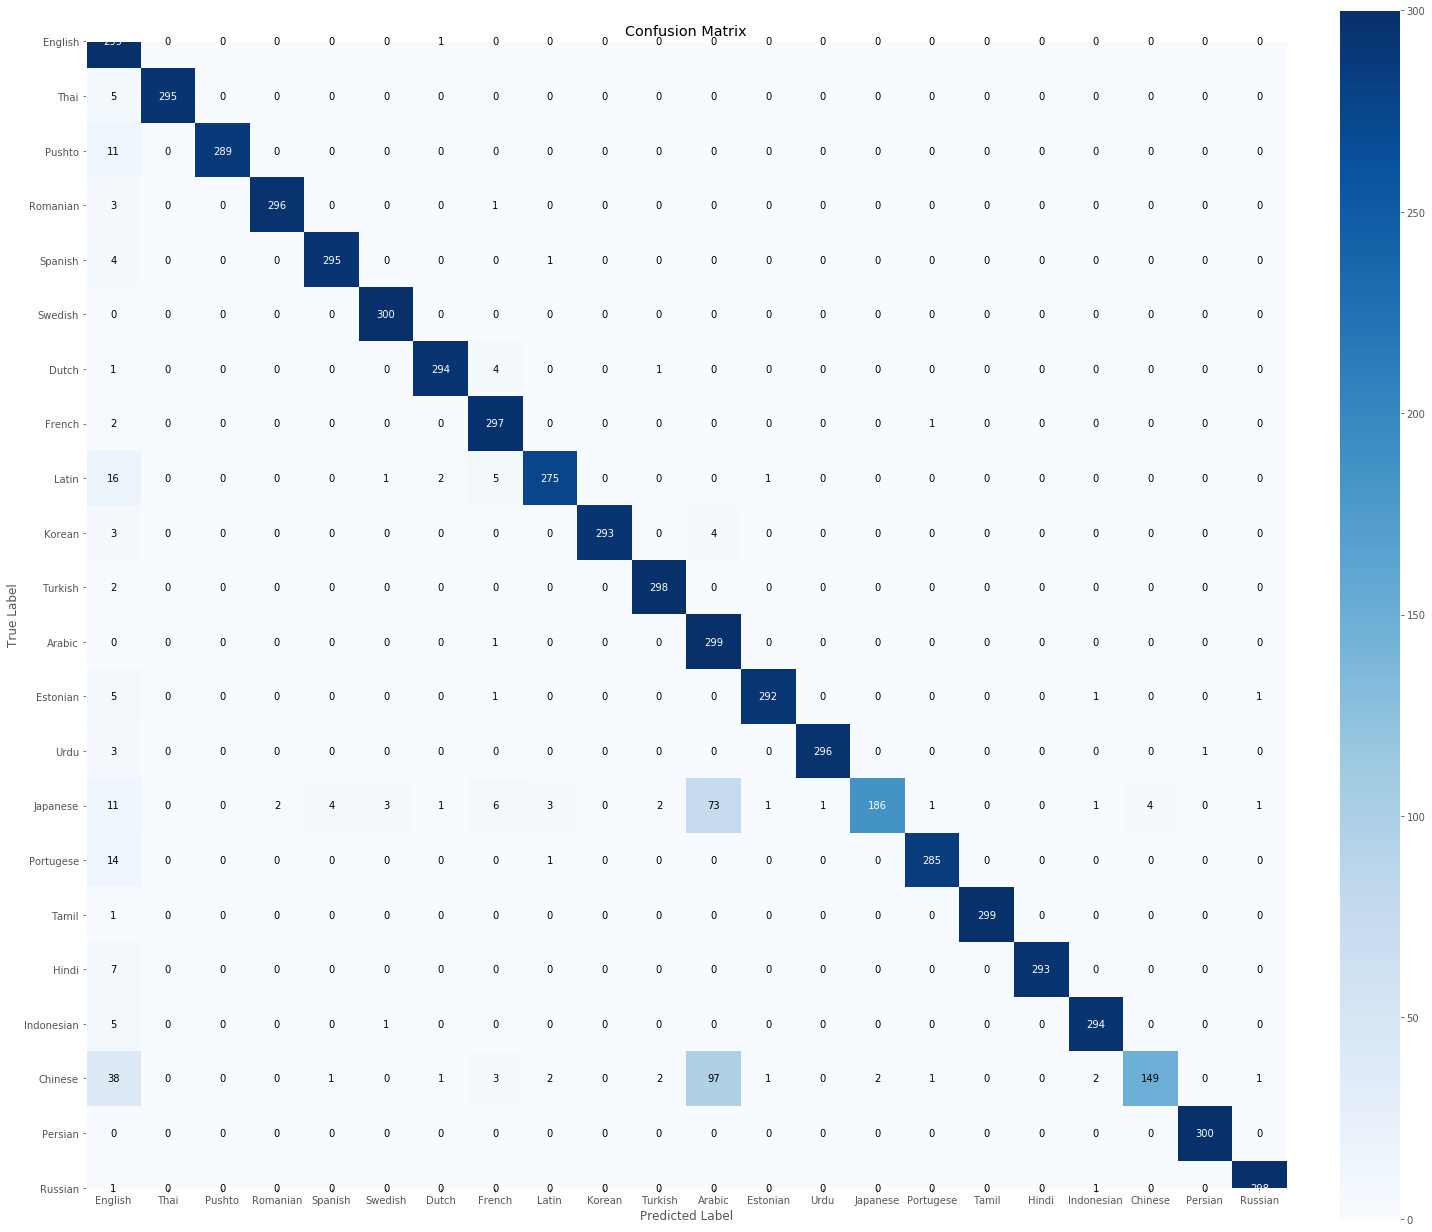

In [34]:
plot_confusion_matrix(Y_test,test_pred,language_list)

In [35]:
f1_score(Y_test,test_pred,average='weighted')

0.9415847335559615

In [36]:
naive_clf2=MultinomialNB(alpha=0.0001)
naive_clf2.fit(X_train,Y_train)

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

0.9489716070031526

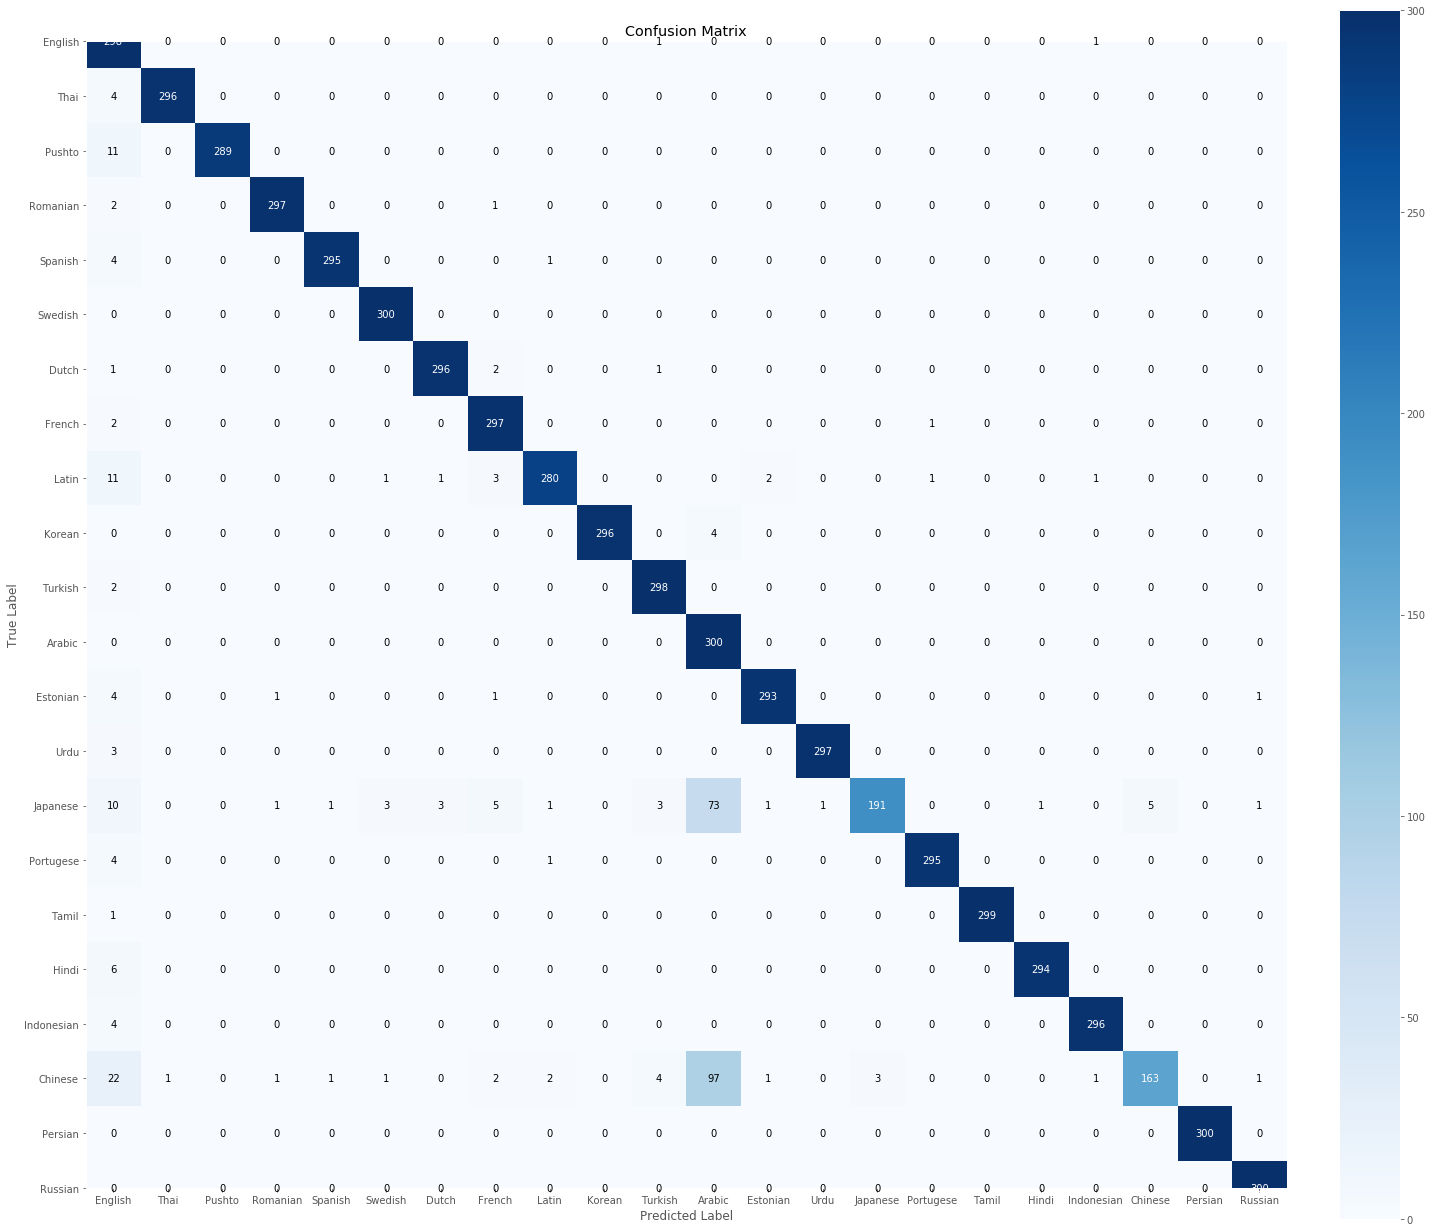

In [37]:
test_pred2=naive_clf2.predict(X_test)
plot_confusion_matrix(Y_test,test_pred2,language_list)
f1_score(Y_test,test_pred2,average='weighted')

In [62]:
from sklearn.svm import SVC
SVM_clf=SVC(C=100,kernel='linear')
SVM_clf.fit(X_train,Y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

94.06620187068853

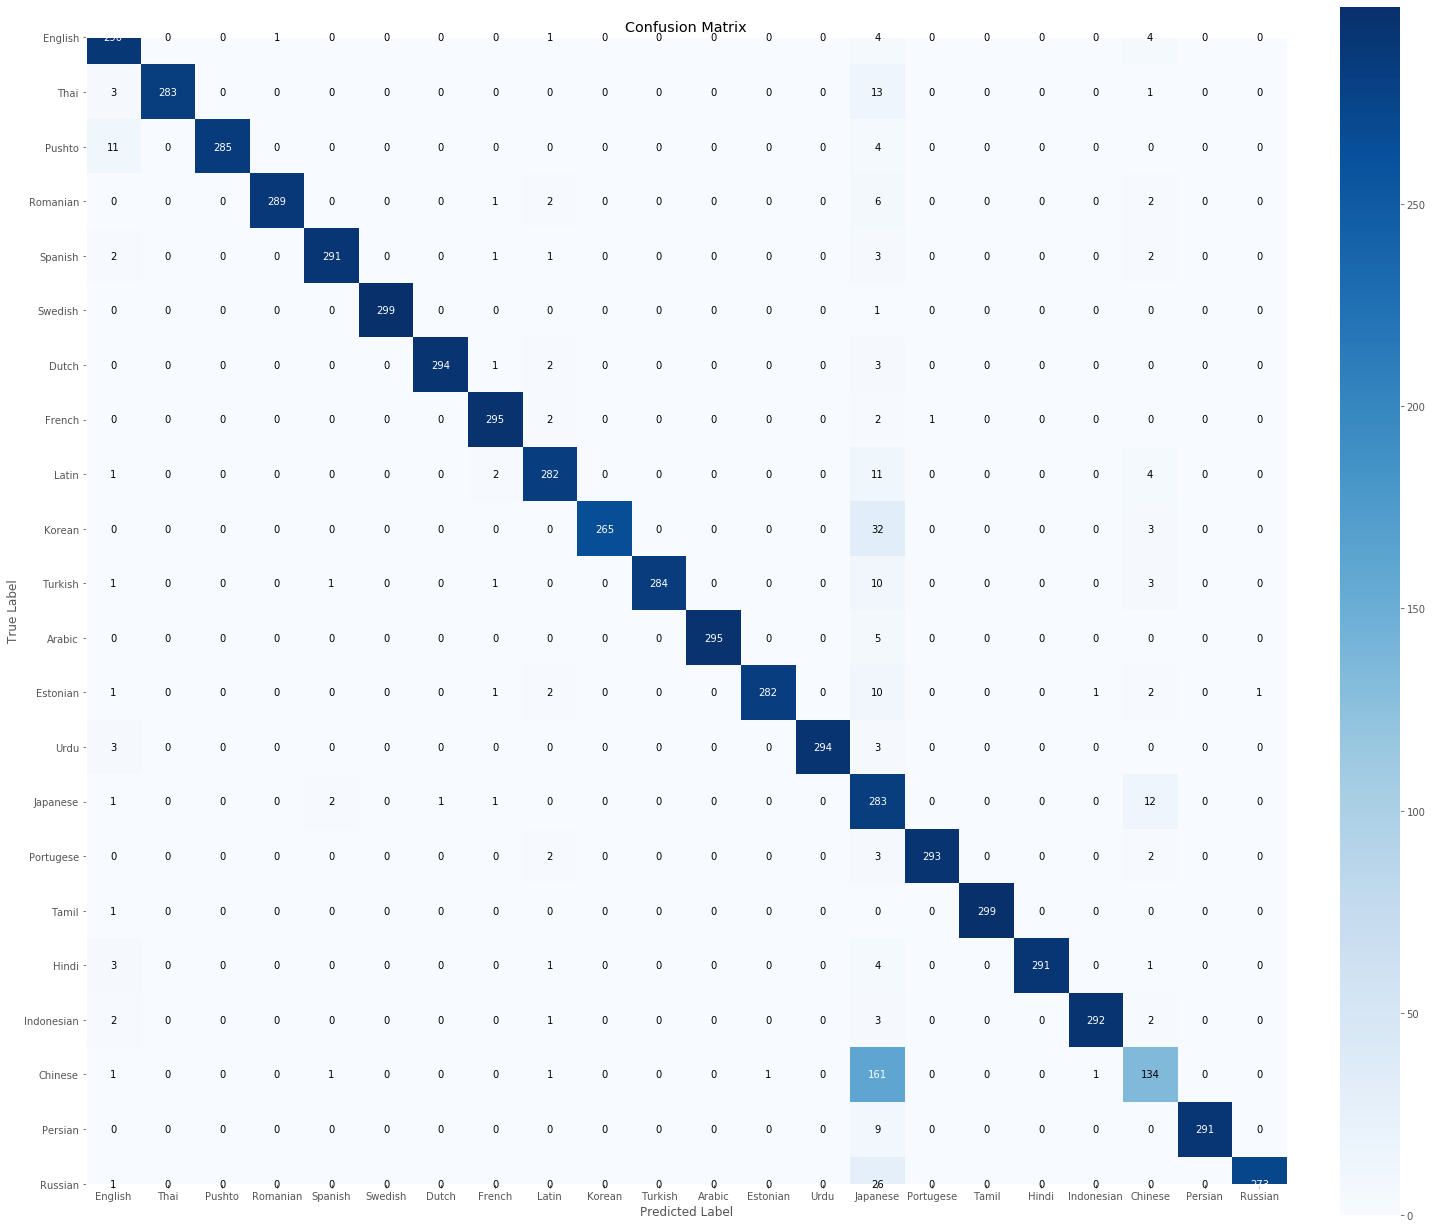

In [63]:
test_pred2=SVM_clf.predict(X_test)
plot_confusion_matrix(Y_test,test_pred2,language_list)
f1_score(Y_test,test_pred2,average='weighted')*100

## Input Text

In [48]:
s=str(input("Enter the text : "))
s

Enter the text : こんにちは、サー・ファック・ユー


'こんにちは、サー・ファック・ユー'

In [53]:
print(type(s))
s_list=[]
s_list.append(s)
print(type(s_list))

<class 'str'>
<class 'list'>


In [54]:
sData=vectorizer.transform(s_list)
sData

<1x216903 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [55]:
sPredict=naive_clf2.predict(sData)

In [56]:
print(sPredict)

['Arabic']
